

![image-20201226152702981](images/image-20201226152702981.png)


数据集State-of-the-Art详见

- [mnist](https://paperswithcode.com/sota/image-classification-on-mnist)
- [fashion-mnist](https://paperswithcode.com/sota/image-classification-on-fashion-mnist)
- [cifar-10](https://paperswithcode.com/sota/image-classification-on-cifar-10)


## 获取数据

首先引入需要的包。

In [1]:
import csv
import ipyparams
import logging
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf
import tensorflow_hub as hub

from collections import Counter
from joblib import Parallel, delayed
from nltk.corpus import stopwords
from scipy import stats
from sklearn import feature_extraction, feature_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, models, layers, regularizers, preprocessing, datasets, metrics, losses, optimizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorboard.plugins.hparams import api as hp 

base_path = os.path.abspath('/tf/eipi10/qbz95')
sys.path.append(base_path)

import qbz95
from qbz95 import tf as qtf

pd.set_option('display.max_colwidth', None)
# 设置GPU内存自动扩增
qtf.utils.set_gpu_memory_growth()
nltk.download('stopwords')

# auto load the changes of referenced codes
%load_ext autoreload
%autoreload 2

# ebablbe auto-completion
%config Completer.use_jedi = False

<IPython.core.display.Javascript object>

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# 当module有新的方法的时候，需要运行下面方法。
%reload_ext autoreload

初始化参数。

In [3]:
def lr_schedule(epoch, lr):
    """config the strategy of reducing learning rate"""
    lr_times = [(0, 1), (60, 1e-1), (90, 1e-2), (105, 1e-3), (120, 0.5e-3)]
    
    base_lr = 1e-3
    new_lr = base_lr
    for border_epoch, times in lr_times:
        if epoch>=border_epoch: 
            new_lr = base_lr*times
    if abs(lr - new_lr)>1e-7:
        if new_lr > lr > 0.1*new_lr - 1e-7:
            print('Epoch %05d: Still keep learning rate %s instead of %s' % 
                  (epoch + 1, round(lr, 7), round(new_lr, 7))) 
            return lr   
        print('Epoch %05d: LearningRateScheduler reducing learning rate to %s from %s.' % 
              (epoch + 1, round(new_lr, 7), round(lr, 7)))
    return new_lr

data_generator = preprocessing.image.ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False) 

output_path = os.path.abspath('./output')
data_name = 'cifar10'
data_path = os.path.join(output_path, data_name)
program_path = os.path.join(data_path, qbz95.utils.get_notebook_name().split('.')[0])
word_vectors_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/word_vectors'
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

params = {
    'data_name': data_name,
    'data_path': data_path,
    'use_data_augmentation': True,
    'augmentation_generator': data_generator,       
    'program_name': qbz95.utils.get_notebook_name(),
    'program_path': program_path,
    'classes': classes,
    'word_vectors_path': word_vectors_path,
    'sample_perecent': 1,    
    'validation_percent': 0.0,  
    'use_stop_words': True,    
    'batch_size': 32,    
    'epochs': 3,    
    'steps_per_epoch': int(60000/32),
    'learning_rate':0.001,
    'clip_value':None,
    'dropout':0.1,
    'metrics':['accuracy'], 
    'loss': losses.SparseCategoricalCrossentropy(from_logits=True),
    'restore_best_checkpoint':True,
    'use_savedmodel':True,
    'use_bias_initializer':False,
    'use_class_weight':False,
    'class_weight': [1.0, 1.0],
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': True,
            'schedule': lr_schedule,            
        }             
    },
    'model_params':{
        'mlp':{'dropout':0.0, 'layer_count':1, 'units':128, 'epochs':120},
        'lenet':{'dropout':0.1, 'epochs':120},
        'custom':{'dropout':0.1, 'epochs':120},
        'vgg':{'dropout':0.3, 'epochs':120},
        'resnet':{'epochs':120}        
    },
    'embedding_paths':{
    },
    'keras_layper_paths':{
    },
    'model_resutls':{
        'show_top_n':20,
        'show_exclude_columns':qtf.classification.ModelResults.exclude_columns1
    }
}

params = qtf.classification.Params(params)
model_results=qtf.classification.ProgramModelResults(params.program_path)
# model_results.clear()

### 下载数据

开始下载数据。

In [4]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

train_images = train_images/255.0   
test_images = test_images/255.0   

train_labels = np.squeeze(train_labels)
test_labels = np.squeeze(test_labels)

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)


(50000, 32, 32, 3) (50000,)
(10000, 32, 32, 3) (10000,)




### 查看数据

下面看一看实际的数据是啥样的。

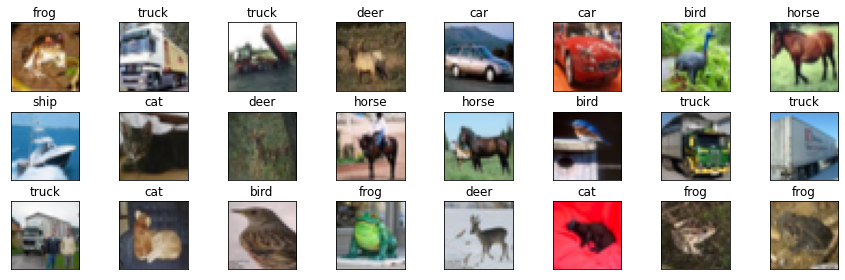

In [5]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### 类别分布

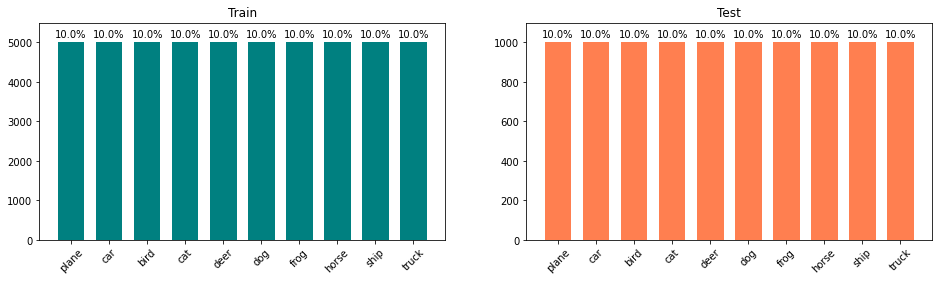

In [6]:
qtf.utils.plot_distribution(train_labels, test_labels, params.classes)



## 准备数据

不同的模型需要准备不同的数据，所以确定一下要构建哪种模型。

### 原始数据


In [7]:
raw_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, batch_size=params.batch_size)

In [8]:
sample_images, sample_labels = iter(raw_datasets.train_dataset).next()

In [9]:
raw_datasets.train_dataset.element_spec

(TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None),
 TensorSpec(shape=(32,), dtype=tf.uint8, name=None))

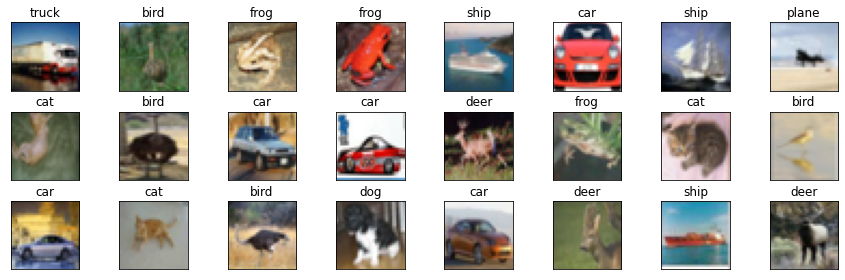

In [10]:
qtf.utils.show_images(sample_images, sample_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### 数据增强

In [11]:
data_generator.fit(train_images)
generator = {'train':qtf.classification.AugmentGenerator('augment', data_generator), 
             'val_test':qtf.classification.DatasetGenerator('val_test')}
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=False)

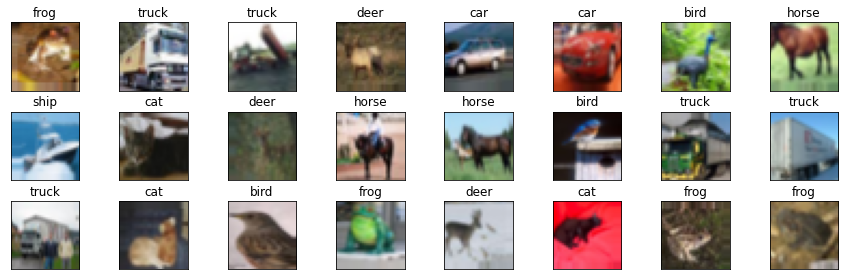

In [12]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

看看图片原始的样子

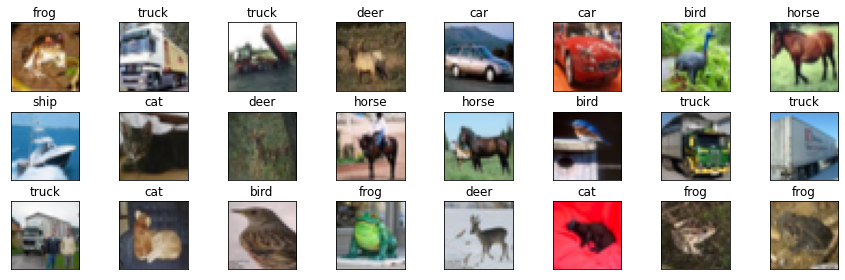

In [13]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

设置随机生成训练数据batch

In [14]:
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=True)

In [15]:
print(f'use_data_augmentation = {params.use_data_augmentation}')
if params.use_data_augmentation:
    datasets = augment_datasets
else:
    datasets = raw_datasets

use_data_augmentation = True


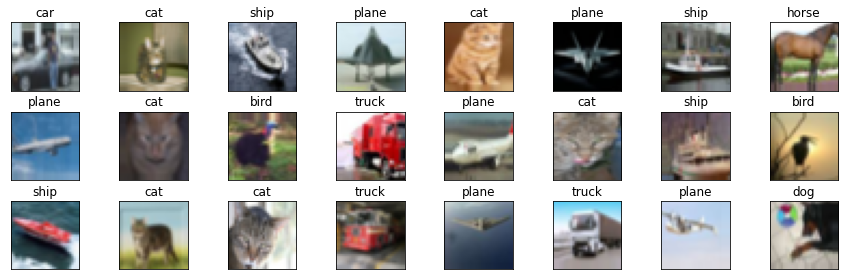

In [16]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 



##  模型

### MLP

2021-08-10 08:05:23,728: INFO: model_params.mlp1.dropout=0.4
2021-08-10 08:05:23,729: INFO: model_params.mlp1.layer_count=1
2021-08-10 08:05:23,730: INFO: model_params.mlp1.units=128
2021-08-10 08:05:23,786: INFO: learning_rate=0.001
2021-08-10 08:05:23,786: INFO: model_params.mlp1.clip_value=None
2021-08-10 08:05:23,805: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1
2021-08-10 08:05:23,807: INFO: model_params.mlp1.epochs=15
2021-08-10 08:05:23,807: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1, monitor=val_accuracy)
2021-08-10 08:05:23,808: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-08-10 08:05:23,809: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-08-10 08:05:23,809: INFO: use LearningRateScheduler()
2021-08-10 08

Model: "mlp1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               393344    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 394,634
Trainable params: 394,634
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1563/1875 [========================>.....] - ETA: 5s - loss: 2.1993 - accuracy: 0.1477WARNING:tensorflow:Your i

2021-08-10 08:05:54,476: WARNING: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 28125 batches). You may need to use the repeat() function when building your dataset.


1875/1875 [==============================] - 31s 16ms/step - loss: 2.1993 - accuracy: 0.1477 - val_loss: 2.1039 - val_accuracy: 0.1948
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1/assets


2021-08-10 08:05:56,290: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1/assets
2021-08-10 08:05:56,816: INFO: finish training [elapsed time: 33.01 seconds]


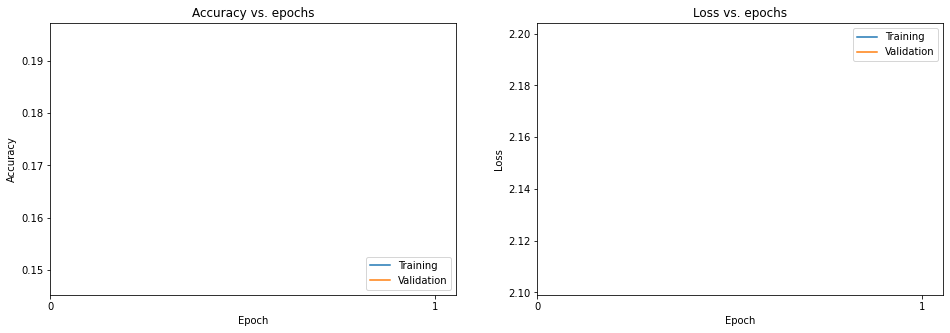

2021-08-10 08:05:57,195: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1
----------------------------------------evaluate----------------------------------------


2021-08-10 08:06:06,388: INFO: test loss:2.1039
2021-08-10 08:06:06,390: INFO: test accuracy:0.1948
2021-08-10 08:06:06,391: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/results.json
2021-08-10 08:06:06,393: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/results.json
2021-08-10 08:06:06,394: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator
2021-08-10 08:06:06,396: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


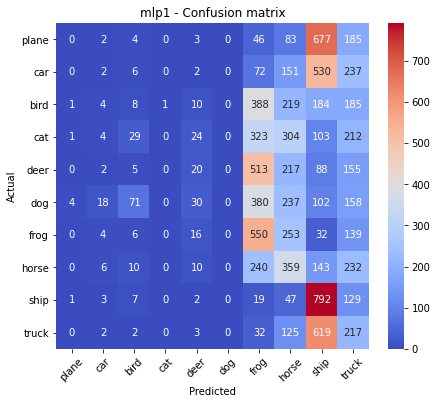

----------------------------------------sample analysis----------------------------------------


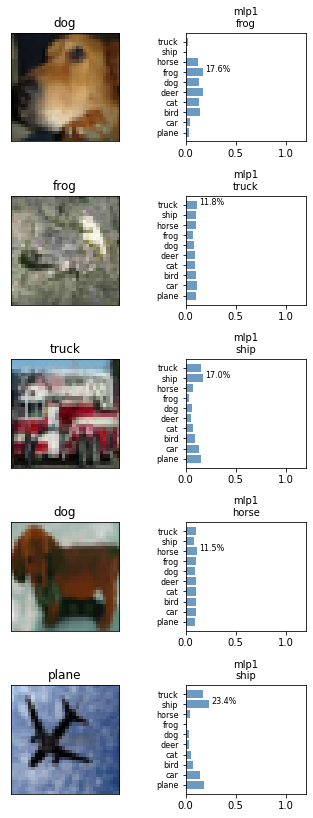

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,mlp1,394634,32.5,2.1044,2.1039,0.1978,0.1948,0.6985,0.6984


In [17]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.mlp1(helper, name='mlp1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 




从上面的错误来看，模型对一些细节的判断不是很准。下面来尝试一下LeNet。

### LeNet

![image-20201019113632136](images/image-20201019113632136.png)

LeNet诞生于1994年，是Yann LeCun等人提出的，是最早的卷积神经网络之一。在LeNet中，输入层是32×32的图片，而MNIST是28×28的图片，为了保持模型的结构不变，在第一个Conv2D设置参数padding=’same’。首先创建模型，并训练。

2021-08-10 08:06:10,090: INFO: model_params.lenet1.dropout=0.2
2021-08-10 08:06:10,184: INFO: learning_rate=0.001
2021-08-10 08:06:10,185: INFO: model_params.lenet1.clip_value=None
2021-08-10 08:06:10,191: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet1
2021-08-10 08:06:10,196: INFO: model_params.lenet1.epochs=15
2021-08-10 08:06:10,196: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet1, monitor=val_accuracy)
2021-08-10 08:06:10,197: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-08-10 08:06:10,198: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-08-10 08:06:10,198: INFO: use LearningRateScheduler()
2021-08-10 08:06:10,199: INFO: steps_per_epoch=1875
2021-08-10 08:06:10,199: INFO: start training
2021-08-10 08:06:10,200: IN

Model: "lenet1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 6)         456       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 6)         24        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 6)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 16)        2416      
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 12, 16)        64   

2021-08-10 08:06:42,168: WARNING: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 28125 batches). You may need to use the repeat() function when building your dataset.


1875/1875 [==============================] - 33s 17ms/step - loss: 1.7903 - accuracy: 0.3463 - val_loss: 1.4490 - val_accuracy: 0.4757
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet1/assets


2021-08-10 08:06:45,226: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet1/assets
2021-08-10 08:06:45,791: INFO: finish training [elapsed time: 35.59 seconds]


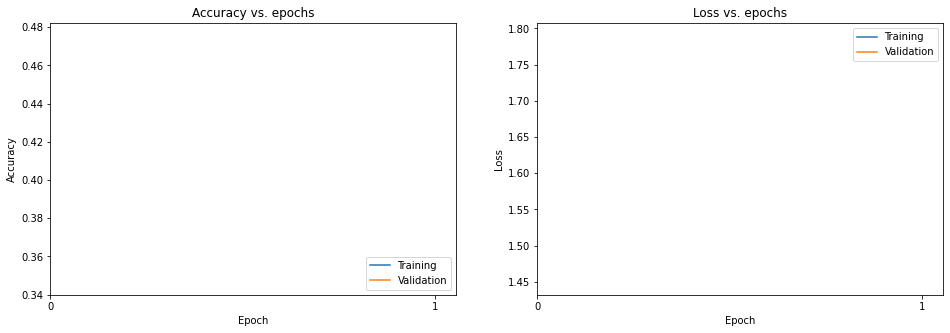

2021-08-10 08:06:46,121: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet1
----------------------------------------evaluate----------------------------------------


2021-08-10 08:06:58,046: INFO: test loss:1.4490
2021-08-10 08:06:58,047: INFO: test accuracy:0.4757
2021-08-10 08:06:58,049: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/results.json
2021-08-10 08:06:58,051: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/results.json
2021-08-10 08:06:58,051: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator
2021-08-10 08:06:58,052: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator
2021-08-10 08:06:58,053: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2021-08-10 08:06:58,322: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator


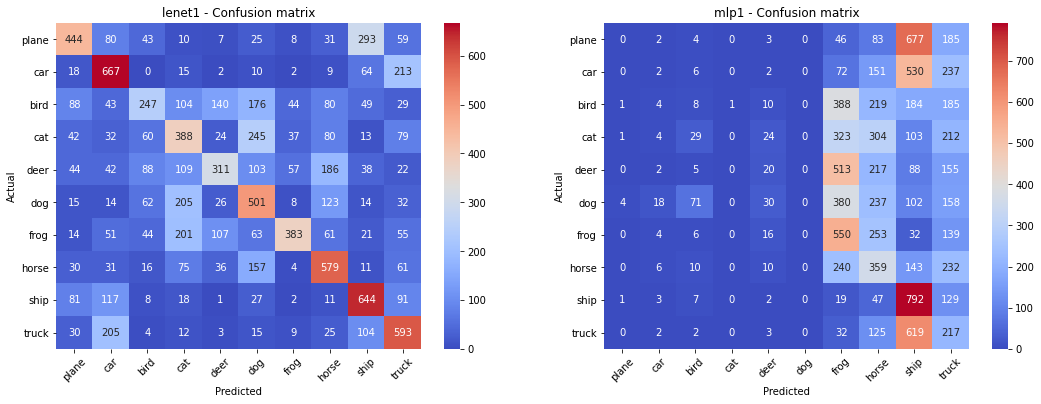

2021-08-10 08:07:02,047: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1


----------------------------------------sample analysis----------------------------------------


2021-08-10 08:07:02,326: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator


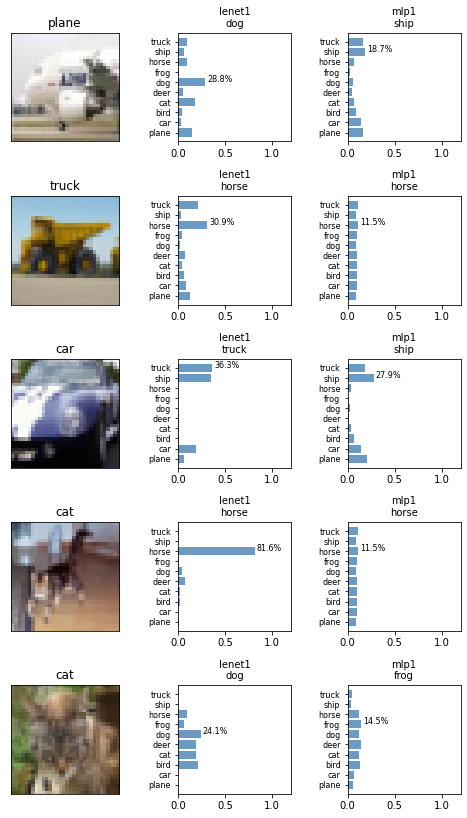

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,lenet1,83170,35.1,1.4518,1.4490,0.4711,0.4757,0.8793,0.8793
2,mlp1,394634,32.5,2.1044,2.1039,0.1978,0.1948,0.6985,0.6984


In [18]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.lenet1(helper, name='lenet1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

从上面的图中，可以看到，Lenet的参数只有mlp的60%，但其的准确率比mlp提升了差不多1%。上面最后一张图中，有三列，第一列是数字图片，它们是mlp中分错的数字，第二列是mlp中的分类，第三列是lenet中的分类，可以看到lenet的确学到了一些mlp中没有的模式。下面再来看看哪些数字在lenet也分错了。

### Custom 1

下面自己定义一个模型，这个模型和lenet的主要区别是，增加了卷积的深度

2021-08-10 08:07:05,453: INFO: model_params.custom1.dropout=0.3
2021-08-10 08:07:05,549: INFO: learning_rate=0.001
2021-08-10 08:07:05,550: INFO: model_params.custom1.clip_value=None
2021-08-10 08:07:05,556: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/custom1
2021-08-10 08:07:05,561: INFO: model_params.custom1.epochs=15
2021-08-10 08:07:05,562: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/custom1, monitor=val_accuracy)
2021-08-10 08:07:05,562: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-08-10 08:07:05,563: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-08-10 08:07:05,564: INFO: use LearningRateScheduler()
2021-08-10 08:07:05,564: INFO: steps_per_epoch=1875
2021-08-10 08:07:05,565: INFO: start training
2021-08-10 08:07:05,56

Model: "custom1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 64)        256 

2021-08-10 08:07:37,104: WARNING: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 28125 batches). You may need to use the repeat() function when building your dataset.


1875/1875 [==============================] - 32s 17ms/step - loss: 1.8481 - accuracy: 0.3239 - val_loss: 1.5039 - val_accuracy: 0.4500
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/custom1/assets


2021-08-10 08:07:40,382: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/custom1/assets
2021-08-10 08:07:40,958: INFO: finish training [elapsed time: 35.39 seconds]


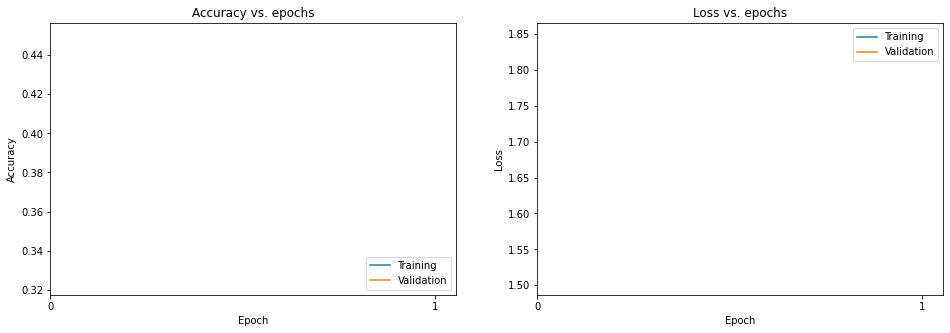

2021-08-10 08:07:41,290: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/custom1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/custom1
----------------------------------------evaluate----------------------------------------


2021-08-10 08:07:54,477: INFO: test loss:1.5039
2021-08-10 08:07:54,478: INFO: test accuracy:0.4500
2021-08-10 08:07:54,481: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/results.json
2021-08-10 08:07:54,483: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/results.json
2021-08-10 08:07:54,484: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator
2021-08-10 08:07:54,486: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator
2021-08-10 08:07:54,487: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2021-08-10 08:07:55,396: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator


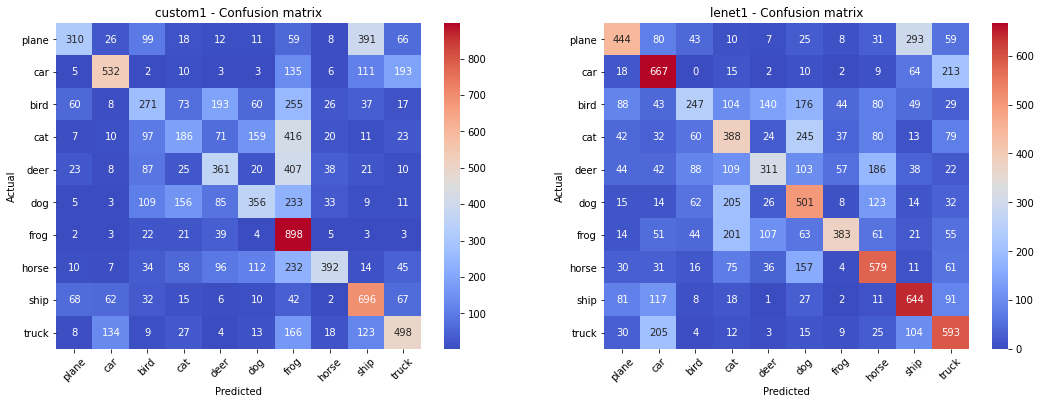

2021-08-10 08:07:59,512: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet1


----------------------------------------sample analysis----------------------------------------


2021-08-10 08:08:00,378: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator
2021-08-10 08:08:00,380: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1
2021-08-10 08:08:00,657: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator


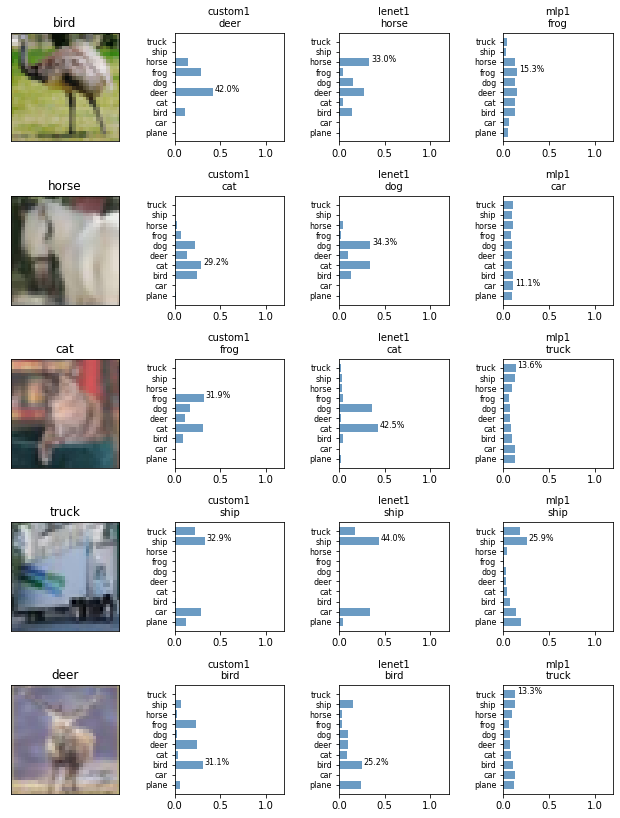

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,lenet1,83170,35.1,1.4518,1.4490,0.4711,0.4757,0.8793,0.8793
2,custom1,73738,34.9,1.5069,1.5039,0.4500,0.4500,0.8800,0.8804
3,mlp1,394634,32.5,2.1044,2.1039,0.1978,0.1948,0.6985,0.6984


In [19]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.custom1(helper, name='custom1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

### VGG

2021-08-10 08:08:04,871: INFO: model_params.vgg8.dropout=0.4
2021-08-10 08:08:05,042: INFO: learning_rate=0.001
2021-08-10 08:08:05,043: INFO: model_params.vgg8.clip_value=None
2021-08-10 08:08:05,050: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8
2021-08-10 08:08:05,057: INFO: model_params.vgg8.epochs=15
2021-08-10 08:08:05,058: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8, monitor=val_accuracy)
2021-08-10 08:08:05,059: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-08-10 08:08:05,059: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-08-10 08:08:05,060: INFO: use LearningRateScheduler()
2021-08-10 08:08:05,060: INFO: steps_per_epoch=1875
2021-08-10 08:08:05,061: INFO: start training
2021-08-10 08:08:05,061: INFO: use_cl

Model: "vgg8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_con1 (Conv2D)         (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_bn1 (BatchNormalizati (None, 32, 32, 64)        256       
_________________________________________________________________
block1_relu1 (ReLU)          (None, 32, 32, 64)        0         
_________________________________________________________________
block1_con2 (Conv2D)         (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_bn2 (BatchNormalizati (None, 32, 32, 64)        256       
_________________________________________________________________
block1_relu2 (ReLU)          (None, 32, 32, 64)        0      

2021-08-10 08:08:37,469: WARNING: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 28125 batches). You may need to use the repeat() function when building your dataset.


1875/1875 [==============================] - 34s 17ms/step - loss: 2.0672 - accuracy: 0.1774 - val_loss: 1.8329 - val_accuracy: 0.2886
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


2021-08-10 08:08:43,221: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets
2021-08-10 08:08:43,850: INFO: finish training [elapsed time: 38.79 seconds]


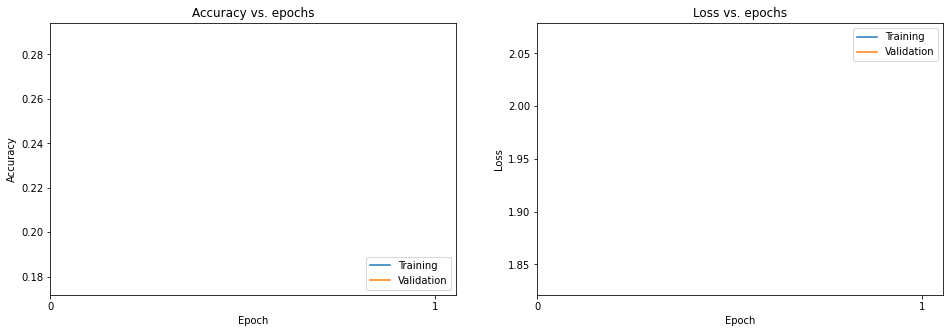

2021-08-10 08:08:44,176: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8
----------------------------------------evaluate----------------------------------------


2021-08-10 08:09:02,330: INFO: test loss:1.8329
2021-08-10 08:09:02,331: INFO: test accuracy:0.2886
2021-08-10 08:09:02,334: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/results.json
2021-08-10 08:09:02,336: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/results.json
2021-08-10 08:09:02,337: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator
2021-08-10 08:09:02,338: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator
2021-08-10 08:09:02,339: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2021-08-10 08:09:03,496: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator


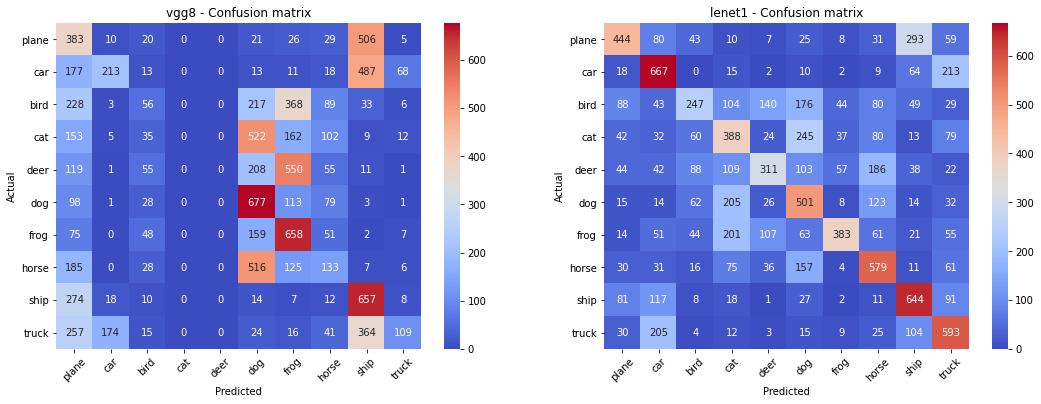

2021-08-10 08:09:07,990: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet1


----------------------------------------sample analysis----------------------------------------


2021-08-10 08:09:08,832: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator
2021-08-10 08:09:08,835: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/custom1
2021-08-10 08:09:09,815: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator
2021-08-10 08:09:09,818: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1
2021-08-10 08:09:10,100: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator


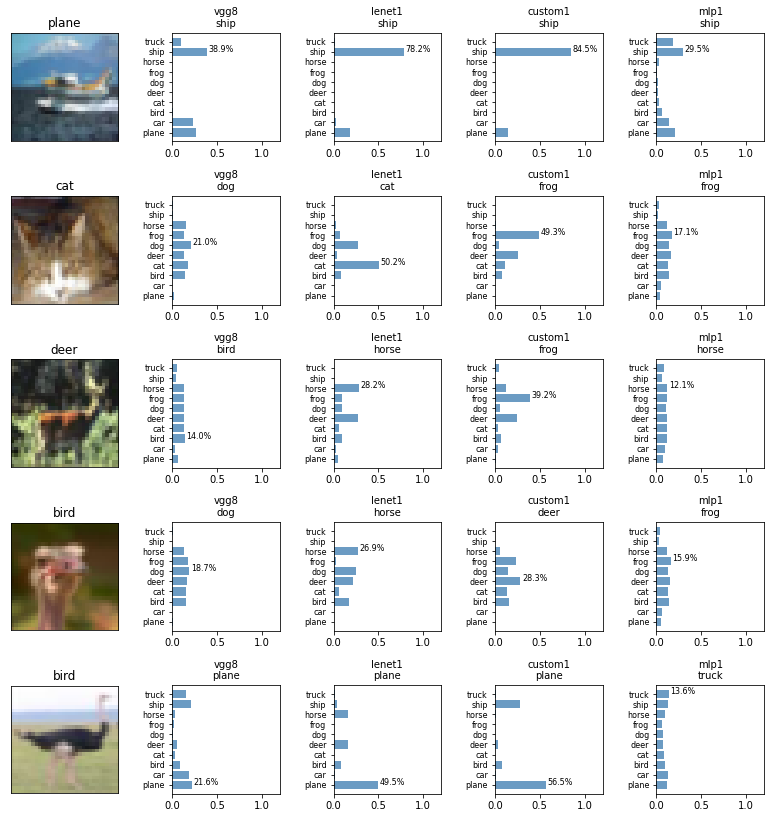

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,lenet1,83170,35.1,1.4518,1.4490,0.4711,0.4757,0.8793,0.8793
2,custom1,73738,34.9,1.5069,1.5039,0.4500,0.4500,0.8800,0.8804
3,vgg8,1672906,38.3,1.8348,1.8329,0.2901,0.2886,0.7975,0.7986
4,mlp1,394634,32.5,2.1044,2.1039,0.1978,0.1948,0.6985,0.6984


In [20]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.vgg1(helper, name='vgg8', dense_layer_count=1, block_count=3,)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

### Resnet

参考https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter2-deep-networks/resnet-cifar10-2.2.1.py

2021-08-10 08:09:16,287: INFO: learning_rate=0.001
2021-08-10 08:09:16,288: INFO: model_params.resnet_v1_20.clip_value=None
2021-08-10 08:09:16,295: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20
2021-08-10 08:09:16,315: INFO: model_params.resnet_v1_20.epochs=15
2021-08-10 08:09:16,315: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20, monitor=val_accuracy)
2021-08-10 08:09:16,316: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-08-10 08:09:16,317: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-08-10 08:09:16,317: INFO: use LearningRateScheduler()
2021-08-10 08:09:16,318: INFO: steps_per_epoch=1875
2021-08-10 08:09:16,318: INFO: start training
2021-08-10 08:09:16,319: INFO: use_class_weight=False


Model: "resnet_v1_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 32, 32, 16)   448         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 32, 32, 16)   64          conv2d_5[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization_5[0][0]      
_______________________________________________________________________________________

1562/1875 [=======================>......] - ETA: 7s - loss: 1.5600 - accuracy: 0.4973WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 28125 batches). You may need to use the repeat() function when building your dataset.


2021-08-10 08:09:57,119: WARNING: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 28125 batches). You may need to use the repeat() function when building your dataset.


1875/1875 [==============================] - 44s 22ms/step - loss: 1.5597 - accuracy: 0.4974 - val_loss: 1.6741 - val_accuracy: 0.5230


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


2021-08-10 08:10:12,207: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets
2021-08-10 08:10:13,074: INFO: finish training [elapsed time: 56.76 seconds]


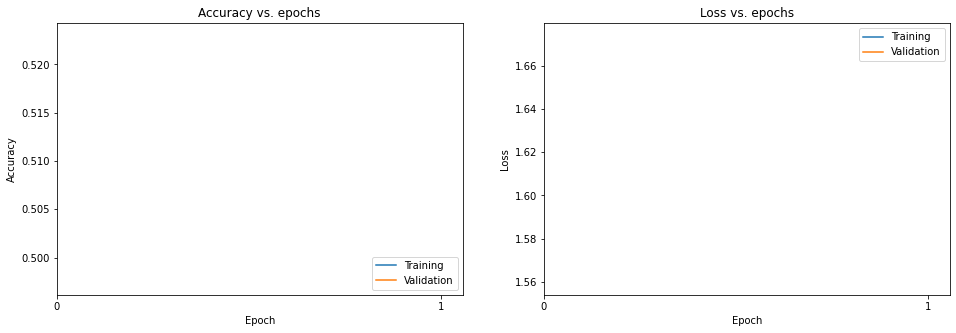

2021-08-10 08:10:13,465: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20
----------------------------------------evaluate----------------------------------------


2021-08-10 08:10:49,250: INFO: test loss:1.6741
2021-08-10 08:10:49,251: INFO: test accuracy:0.5230
2021-08-10 08:10:49,256: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/results.json
2021-08-10 08:10:49,258: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/results.json
2021-08-10 08:10:49,258: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator
2021-08-10 08:10:49,260: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator
2021-08-10 08:10:49,260: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2021-08-10 08:10:50,105: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator


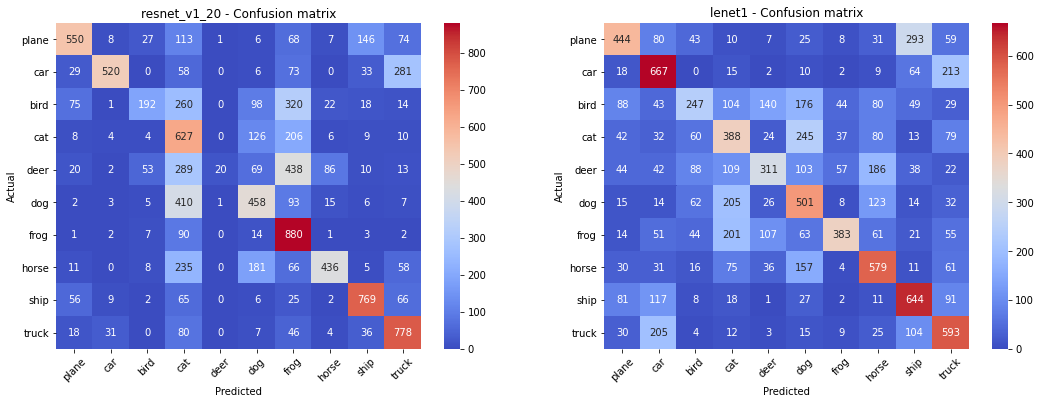

2021-08-10 08:10:55,617: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet1


----------------------------------------sample analysis----------------------------------------


2021-08-10 08:10:56,451: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator
2021-08-10 08:10:56,453: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/custom1
2021-08-10 08:10:57,742: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator
2021-08-10 08:10:57,745: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8
2021-08-10 08:10:59,398: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator
2021-08-10 08:10:59,401: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_

2021-08-10 08:11:02,690: WARNING: 5 out of the last 631 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f2ccc35f158> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


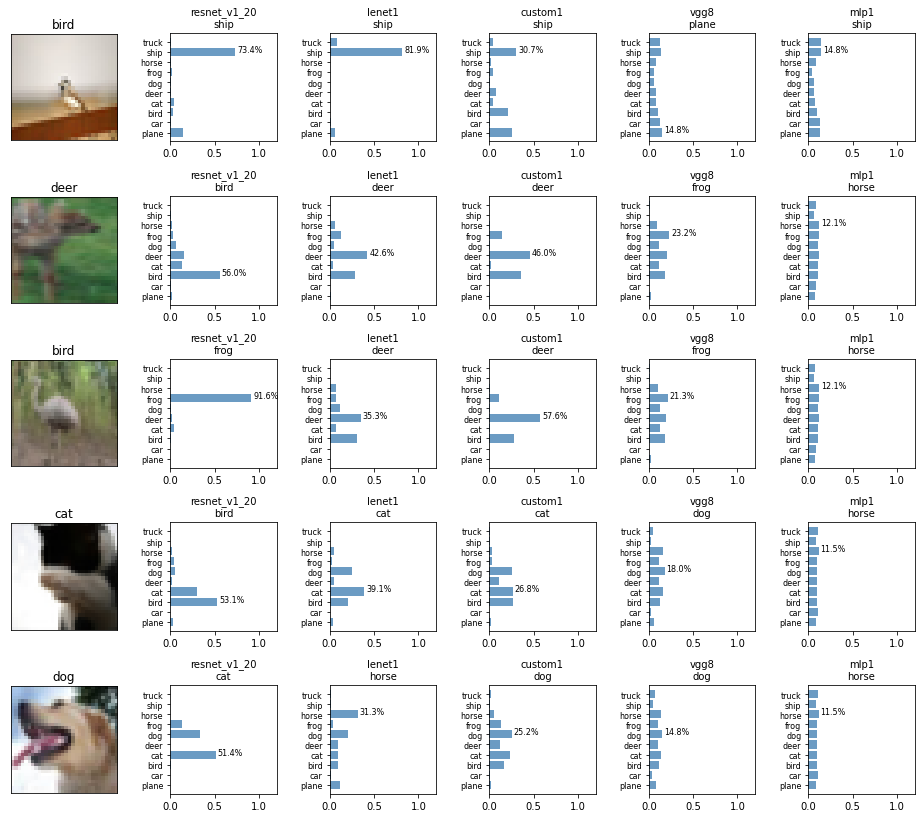

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,resnet_v1_20,273066,56.3,1.6290,1.6741,0.5311,0.5230,0.9148,0.9110
2,lenet1,83170,35.1,1.4518,1.4490,0.4711,0.4757,0.8793,0.8793
3,custom1,73738,34.9,1.5069,1.5039,0.4500,0.4500,0.8800,0.8804
4,vgg8,1672906,38.3,1.8348,1.8329,0.2901,0.2886,0.7975,0.7986
5,mlp1,394634,32.5,2.1044,2.1039,0.1978,0.1948,0.6985,0.6984


In [21]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.resnet_v1(helper, name='resnet_v1', depth=20)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

## 评估

### 最佳模型

In [22]:
data_model_results = qtf.classification.DataModelResults(params.data_path) 
data_model_results.show(10)

2021-08-10 08:11:07,474: INFO: getting results for /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10
2021-08-10 08:11:07,476: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/results.json
2021-08-10 08:11:07,477: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/results.json


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,resnet_v1_20,273066,52.9,1.2199,1.2788,0.6244,0.6043,0.9389,0.9323
2,resnet_v1_20,273066,56.3,1.6290,1.6741,0.5311,0.5230,0.9148,0.9110
3,lenet1,83170,35.1,1.4518,1.4490,0.4711,0.4757,0.8793,0.8793
4,lenet1,83170,11.7,1.4436,1.4719,0.4819,0.4694,0.8843,0.8798
5,custom1,73738,12.5,1.5206,1.5230,0.4620,0.4631,0.8826,0.8817
6,custom1,73738,34.9,1.5069,1.5039,0.4500,0.4500,0.8800,0.8804
7,vgg8,1672906,38.3,1.8348,1.8329,0.2901,0.2886,0.7975,0.7986
8,vgg8,1672906,28.1,2.0004,2.0017,0.2489,0.2480,0.7923,0.7906
9,mlp1,394634,32.5,2.1044,2.1039,0.1978,0.1948,0.6985,0.6984
10,mlp1,394634,6.6,2.0926,2.0935,0.1834,0.1859,0.7018,0.7009


2021-08-10 08:11:07,553: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/resnet_v1_20
2021-08-10 08:11:12,431: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/default.generator
2021-08-10 08:11:12,434: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20
2021-08-10 08:11:17,835: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator
2021-08-10 08:11:17,838: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet1
2021-08-10 08:11:18,685: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05

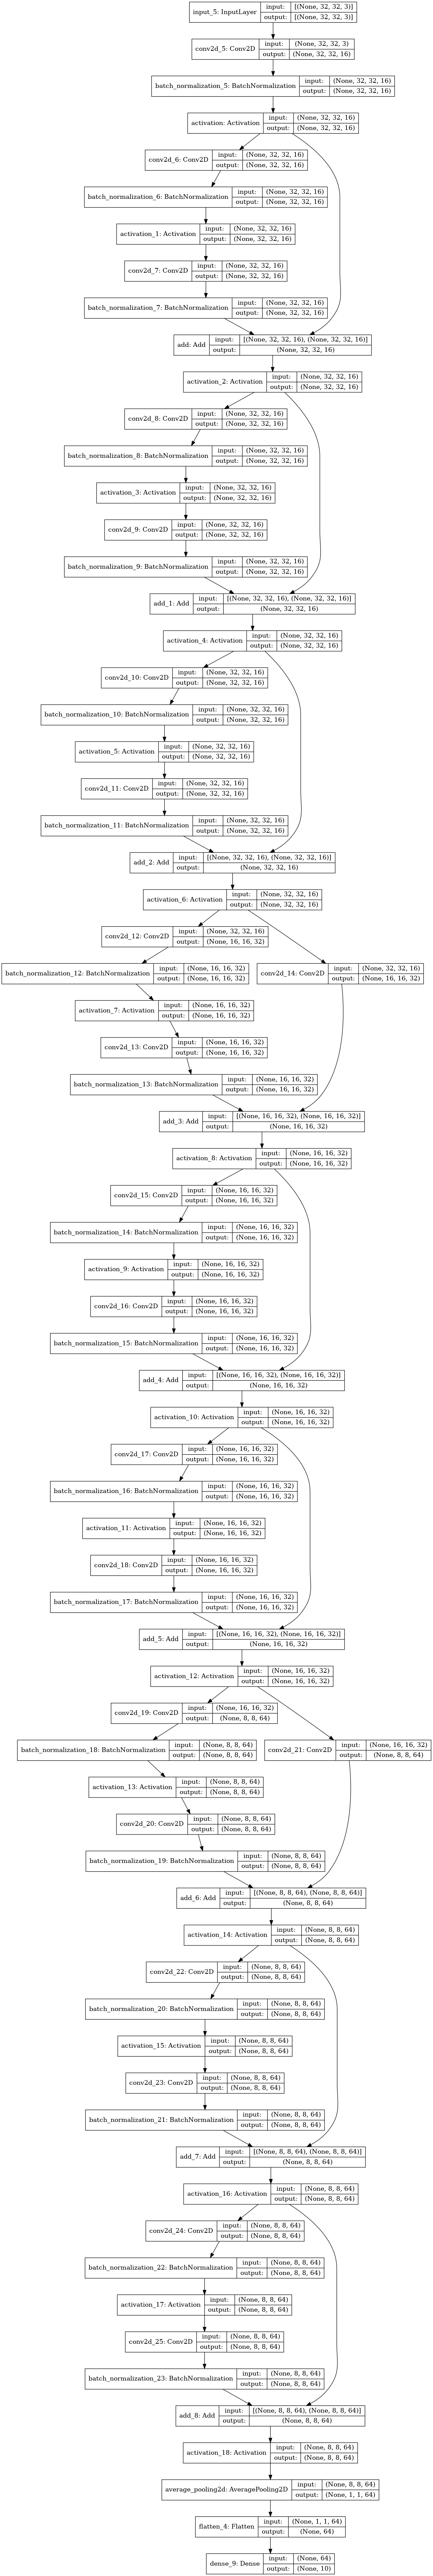

In [23]:

predictors = qtf.classification.Predictor.get_top_n_predictors(5, data_model_results)

best_predictor = predictors[0]
best_predictor.model.compile(optimizer=optimizers.Adam(learning_rate=params.learning_rate),
                        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy', 'mae'])

qtf.utils.plot_model_structure(best_predictor.model)

2021-08-10 08:11:24,167: WARNING: 5 out of the last 25 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f2d604a1598> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


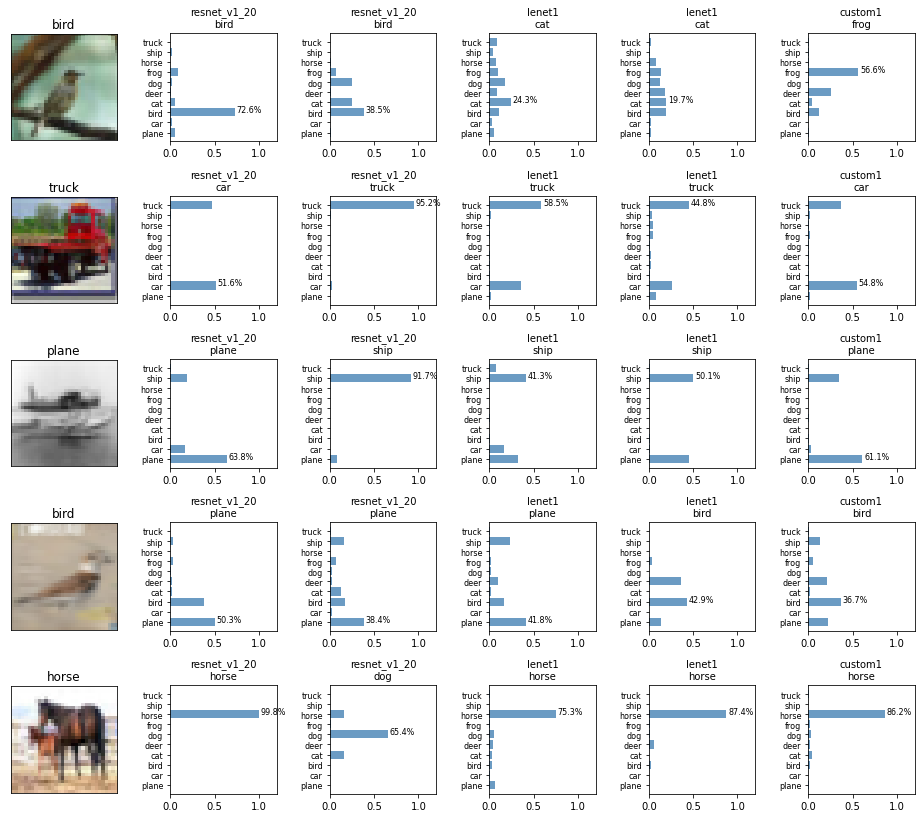

In [24]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=False) 

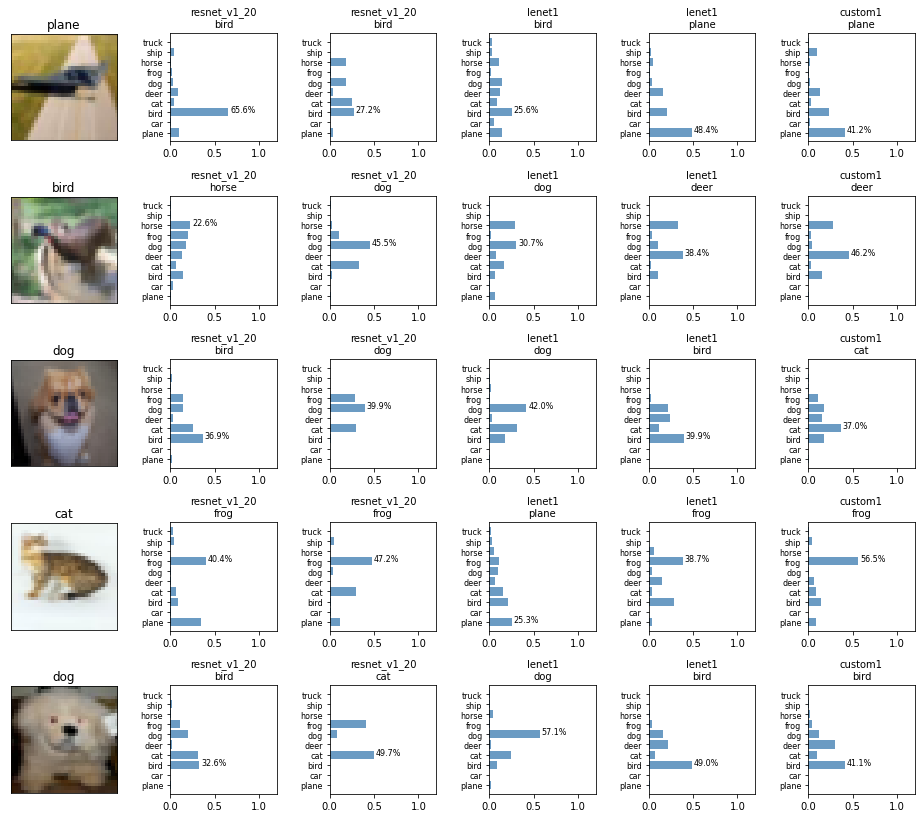

In [25]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=True) 

### 评估

In [26]:
results = best_predictor.evaluate(test_images, test_labels)
print(results)

predictions = best_predictor.predict(test_images)
print(predictions.shape)

{'loss': 1.27878999710083, 'accuracy': 0.6043000221252441, 'mae': 5.908422946929932}
(10000, 10)


In [27]:
top1_predictions = best_predictor.predict_top_k(test_images, test_labels, top_k=1)
top1_scores = qtf.utils.score(test_labels, top1_predictions, params.classes)
display(top1_scores)
print('-'*100)
print(classification_report(test_labels, top1_predictions, digits=4, target_names=params.classes))

,precision,recall,f1
plane,0.605150,0.705,0.651270
car,0.666667,0.864,0.752613
bird,0.462738,0.534,0.495822
cat,0.483163,0.330,0.392157
deer,0.729017,0.304,0.429076
dog,0.630616,0.379,0.473454
frog,0.503614,0.836,0.628571
horse,0.625433,0.723,0.670686
ship,0.676937,0.725,0.700145
truck,0.806775,0.643,0.715637


----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

       plane     0.6052    0.7050    0.6513      1000
         car     0.6667    0.8640    0.7526      1000
        bird     0.4627    0.5340    0.4958      1000
         cat     0.4832    0.3300    0.3922      1000
        deer     0.7290    0.3040    0.4291      1000
         dog     0.6306    0.3790    0.4735      1000
        frog     0.5036    0.8360    0.6286      1000
       horse     0.6254    0.7230    0.6707      1000
        ship     0.6769    0.7250    0.7001      1000
       truck     0.8068    0.6430    0.7156      1000

    accuracy                         0.6043     10000
   macro avg     0.6190    0.6043    0.5909     10000
weighted avg     0.6190    0.6043    0.5909     10000



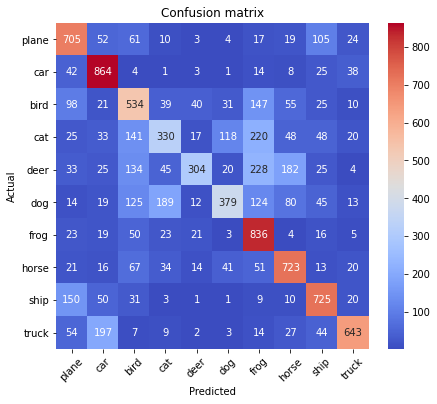

In [28]:
qtf.utils.plot_confusion_matrix(test_labels, top1_predictions, params.classes)


## 参考

- [Text classification Guide](https://developers.google.com/machine-learning/guides/text-classification)

In [29]:
type(helper.datasets.train_dataset)

tensorflow.python.keras.preprocessing.image.NumpyArrayIterator